In [125]:
#importar bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import re
import seaborn as sns

# LEITURA DOS DADOS

In [126]:
# Pasta contendo os arquivos JSON
pasta_keywords = 'keywords_k'

# Lista para armazenar os DataFrames de cada arquivo
dataframes = []

# Itera sobre os arquivos na pasta
for nome_arquivo in os.listdir(pasta_keywords):
    caminho_arquivo = os.path.join(pasta_keywords, nome_arquivo)

    try:
        # Extrai o valor de k do nome do arquivo
        match = re.search(r'keywords_k=(\d+)', nome_arquivo)
        if match:
            k_value = int(match.group(1))
        else:
            k_value = None

        # Leitura do arquivo JSON com o encoding utf-8-sig
        with open(caminho_arquivo, 'r', encoding='utf-8-sig') as f:
            data = json.load(f)

        # Extrai a lista de itens sob a chave 'items'
        items = data.get('network', {}).get('items', [])

        # Converte para DataFrame
        df = pd.json_normalize(items)

        # Adiciona uma coluna 'k' com o valor extraído do nome do arquivo
        df['k'] = k_value

        # Adiciona o DataFrame à lista
        dataframes.append(df)

        # Conta o número de clusters únicos para cada valor de k
        num_clusters = df['cluster'].nunique()

    except json.JSONDecodeError as e:
        print(f"Erro ao decodificar o JSON em {caminho_arquivo}: {e}")
    except Exception as e:
        print(f"Erro desconhecido em {caminho_arquivo}: {e}")

# Concatena todos os DataFrames em um único DataFrame
df_completo = pd.concat(dataframes, ignore_index=True)

#Ordena o DataFrame por k
df_completo.sort_values(by='k', inplace=True)

# imprimir a cabeça do dataframe
df_completo.head()

,id,label,x,y,cluster,weights.Links,weights.Total link strength,weights.Occurrences,scores.Avg. pub. year,scores.Avg. citations,scores.Avg. norm. citations,k
0,3,100 % reserves,1.0075,-0.1745,15,8.0,8.0,1.0,2017.0,3.0,0.8229,1
645,1494,p0,-0.7415,0.1297,7,8.0,8.0,1.0,2021.0,0.0,0.0000,1
646,1495,p00,-0.5293,0.2064,16,9.0,9.0,1.0,2019.0,7.0,2.1990,1
647,1496,p1,-0.4170,-0.0187,7,7.0,7.0,1.0,2021.0,0.0,0.0000,1
648,1498,p14,0.2940,0.5331,18,19.0,20.0,2.0,2021.0,0.5,0.2874,1


In [127]:
#Obter quantos k unicos existem no df_completo
kNumber = df_completo['k'].nunique()
kNumber

10

In [128]:
cluster_info = {}
for label in df_completo['label'].unique():
    # Filtra o DataFrame para o label específico
    label_df = df_completo[df_completo['label'] == label]

    for i in range(kNumber+1):
        clusteri = label_df[label_df['k'] == i]['cluster'].values[0] if label_df[label_df['k'] == i].shape[0] > 0 else 0
        cluster_info.setdefault(i, []).append(clusteri)

# Cria um DataFrame a partir do dicionário
df_cluster_info = pd.DataFrame(cluster_info)

#adicionar na coluna 0 o nome do label
df_cluster_info.insert(0, 'label', df_completo['label'].unique())

df_cluster_info

,label,0,1,2,3,4,5,6,7,8,9,10
0,100 % reserves,0,15,0,0,0,0,0,0,0,0,0
1,p0,0,7,0,0,0,0,0,0,0,0,0
2,p00,0,16,0,0,0,0,0,0,0,0,0
3,p1,0,7,0,0,0,0,0,0,0,0,0
4,p14,0,18,7,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
994,garrison,0,0,25,0,0,0,0,0,0,0,0
995,interpretive economics,0,0,8,0,0,0,0,0,0,0,0
996,foreign intervention,0,0,3,0,0,0,0,0,0,0,0
997,fiduciary media,0,0,10,0,0,0,0,0,0,0,0


In [129]:
#para cada linha do df_cluster_info, contar a quantos clusteres elas pertencem
df_cluster_info['num_clusters'] = df_cluster_info.iloc[:, 1:].astype(bool).sum(axis=1)

df_cluster_stable = df_cluster_info

#ordenar o df_cluster_info por num_clusters decrescente
#df_cluster_stable.sort_values(by='num_clusters', ascending=False, inplace=True)
df_cluster_info

,label,0,1,2,3,4,5,6,7,8,9,10,num_clusters
0,100 % reserves,0,15,0,0,0,0,0,0,0,0,0,1
1,p0,0,7,0,0,0,0,0,0,0,0,0,1
2,p00,0,16,0,0,0,0,0,0,0,0,0,1
3,p1,0,7,0,0,0,0,0,0,0,0,0,1
4,p14,0,18,7,0,0,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,garrison,0,0,25,0,0,0,0,0,0,0,0,1
995,interpretive economics,0,0,8,0,0,0,0,0,0,0,0,1
996,foreign intervention,0,0,3,0,0,0,0,0,0,0,0,1
997,fiduciary media,0,0,10,0,0,0,0,0,0,0,0,1


In [165]:
#para cada coluna do df_cluster_info, armazenar o maior valor encontrado
maxTam = 0
df_cluster_info[1][1]

for coluna in df_cluster_info.columns:
    if coluna != 'label' and coluna != 'num_clusters' and df_cluster_info[coluna].max() > maxTam:
        maxTam = df_cluster_info[coluna].max()

#criar o df kclusteres de clusteres unicos x k preenchido com 0
df_kclusters = pd.DataFrame(0, index=np.arange(maxTam+1), columns=np.arange(kNumber+1))

#para cada linha do df_cluster_info, soma 1 df_kclusters na posicao [cluster+1][k+1]

for coluna in df_cluster_info.columns:
    for linha in df_cluster_info.index:
        if coluna != 'label' and coluna != 'num_clusters':

            df_kclusters[coluna][df_cluster_info[coluna][linha]] += 1

df_kclusters


,0,1,2,3,4,5,6,7,8,9,10
0,999,22,483,725,809,867,907,919,932,942,951
1,0,56,43,32,34,24,22,21,19,14,11
2,0,52,43,26,28,21,15,21,14,14,11
3,0,42,42,24,27,16,14,13,11,13,9
4,0,38,35,24,25,16,13,10,10,10,9
5,0,38,33,21,20,15,13,8,8,6,8
6,0,35,32,21,15,14,11,7,5,0,0
7,0,34,28,21,14,13,4,0,0,0,0
8,0,33,27,20,11,13,0,0,0,0,0
9,0,32,25,18,8,0,0,0,0,0,0


# Graficos

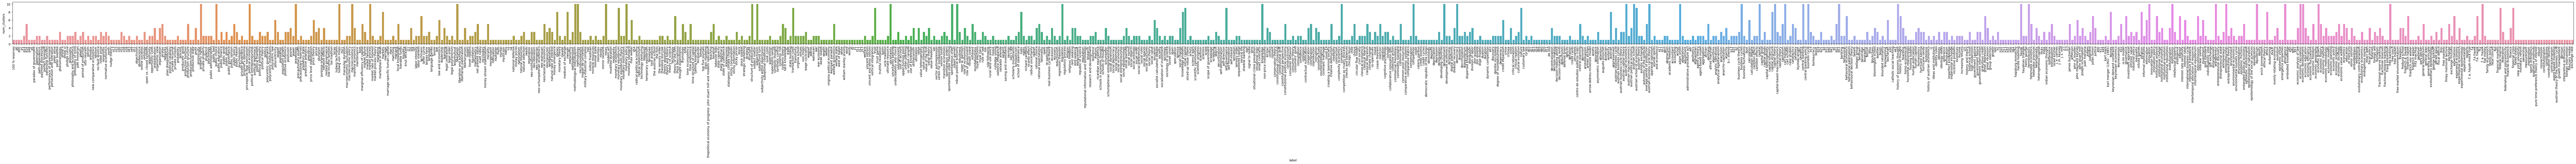

In [131]:
#plotar um grafico de barras com o numero de clusters por label
plt.figure(figsize=(150, 5))
sns.barplot(x='label', y='num_clusters', data=df_cluster_info)
plt.xticks(rotation=90)
plt.subplots_adjust(bottom=0.5)
plt.savefig('figure/allLabels.png')
plt.show()

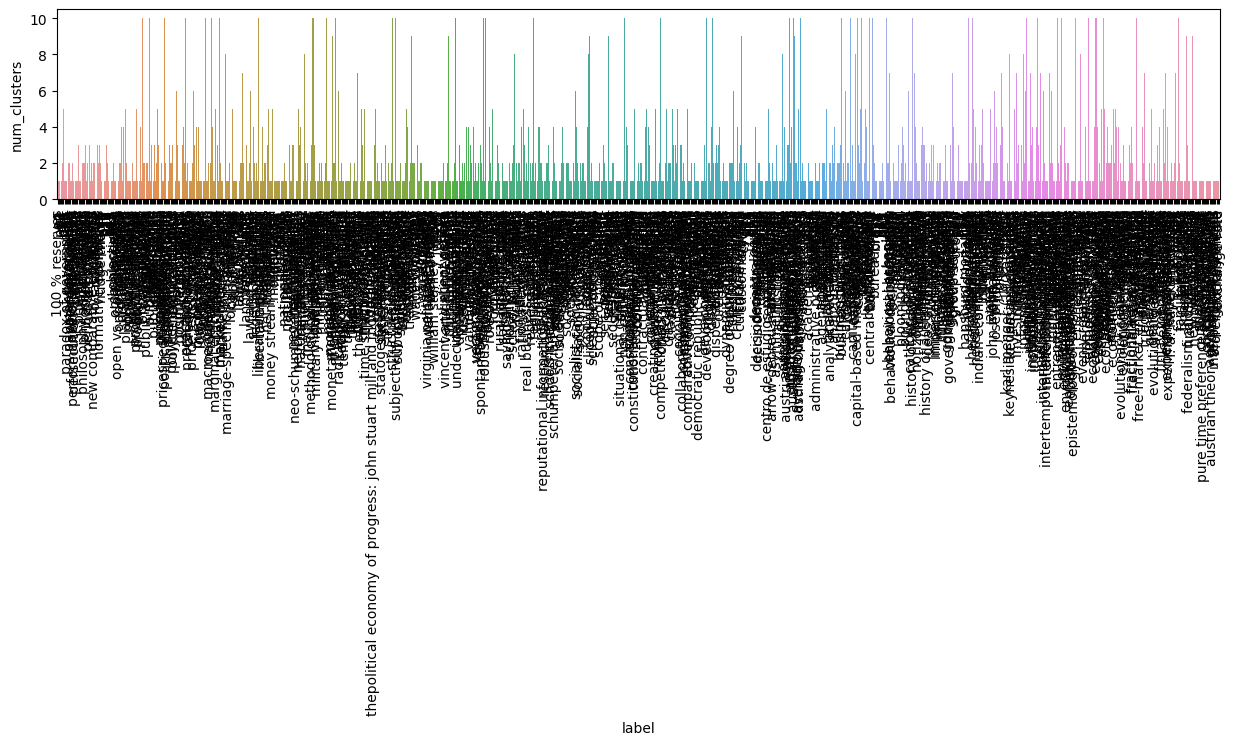

In [132]:
#dropar labels com num_clusters < 5
#df_cluster_info = df_cluster_info[df_cluster_info['num_clusters'] >= 7]

#plotar um grafico de barras com o numero de clusters por label e salvar em figure/importantLabels.png
plt.figure(figsize=(15, 5))
sns.barplot(x='label', y='num_clusters', data=df_cluster_info)
plt.xticks(rotation=90)
plt.subplots_adjust(bottom=0.5)
plt.savefig('figure/importantLabels.png')
plt.show()
